#[BIML-Workshop] Pre-trained Models for Transfer Learning(1)-CNN

#실습 목표 : 사전학습 모델 실습
1. Multi Layer Perceptron & Convolution Neural Network  성능 비교
2. ResNet의 코드 학습
3. ResNet기반 CIFAR 100 data로 사전학습 한 후에 CIFAR 10 data 로 전이학습 3가지 방식 진행

*   전체 모델 새로 학습
*   Convolution base 일부 고정
*   Convolution base 전체 고정 ( 실습 )

4. VGGNet으로 전이학습 직접해보기 ( 실습 )

# Googel drive mount


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#데이터 확보
학습에 사용될 데이터를 다운받습니다.
CIFAR (  Canadian Institute For Advanced Research )

CIFAR-10 데이터셋은 머신러닝 연구에 가장 활발히 사용되는 데이터셋으로, 2009년에 제프리 힌튼 교수팀이 만들었습니다. 10개의 클래스(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)로 이루어진 6만 개의 이미지 데이터셋입니다.

CIFAR-100 역시 32 x 32 크기의 60000개의 이미지로 이루어져 있으며,
100개의 클래스로 분류(dolphin, fish ...) 되며 각각의 클래스는 600개의 이미지로 이루어져 있습니다.

다운 받을 때에 transform을 통해 데이터를 전처리 합니다. 전처리는 모델에 이미지를 넣어주기에 앞서 학습이 좀 더 원활 하게 될 수 있도록 이미지의 픽셀 값을 정규화 시켜주는 과정입니다.  




transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transofrms.Normalize((R채널 평균, G채널 평균, B채널 평균), (R채널 표준편차, G채널 표준편차, B채널 표준편차))

#CIFAR 10 이미지 다운로드

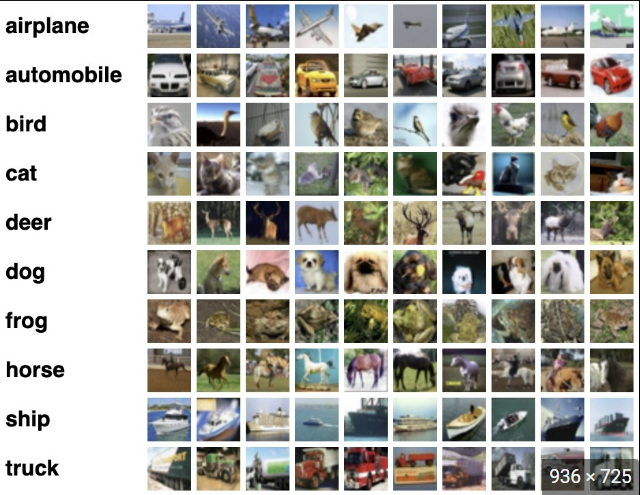



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms



transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# CIFAR 100 이미지 다운로드

In [ ]:
trainset_100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader_100 = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset_100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader_100 = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


# Multi Layer Perceptron 모델 구성하기

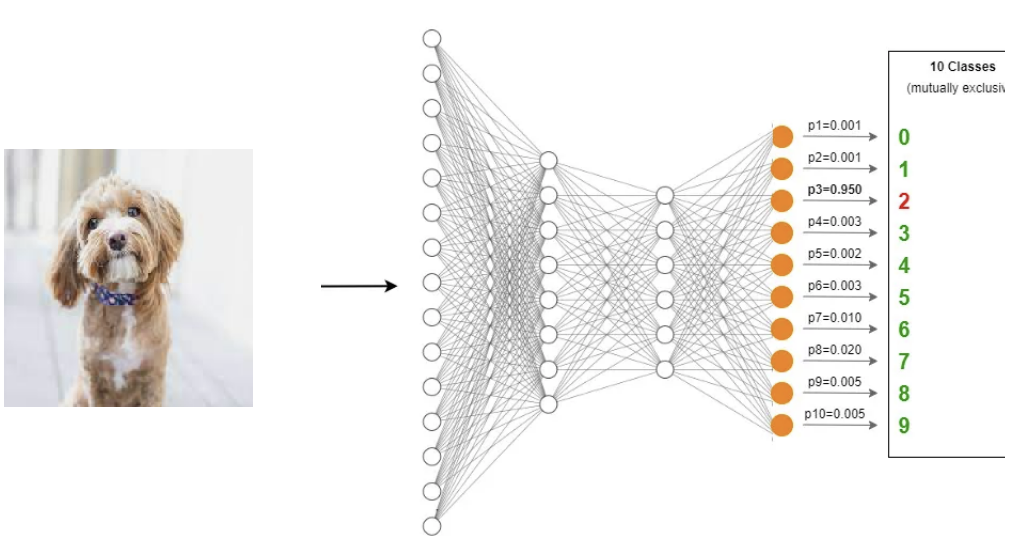

2D 이미지를 Flatten 해서 4개의 Fully Connected Layer(선형 Layer) 와 1개의 Relu function(비선형 Layer)를 교차시켜서 만들어진 MLP 모델을 학습합니다

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
  def __init__(self,in_channel,hidden_dim, out_channel):
    super().__init__()

    # MLP의 기본이 되는 fc layer 4개를 구상합니다.

    self.Linear1 = nn.Linear(in_channel,hidden_dim[0])
    self.Linear2 = nn.Linear(hidden_dim[0],hidden_dim[1])
    self.Linear3 = nn.Linear(hidden_dim[1],hidden_dim[2])
    self.Linear4 = nn.Linear(hidden_dim[2],out_channel)




  def forward(self,x):
    # batch size를 제외한 차원을 flatten 시켜줍니다.

    x = torch.reshape(x,(16,-1))


    x = self.Linear1(x)
    x = self.Linear2(x)
    x = self.Linear3(x)
    x = F.relu(x)
    x = self.Linear4(x)
    return x





#Convolution Neural Network 모델 구성하기
4개의 Convolution filter layer, max pooling layer , fc layer로 이루어져 있는 CNN

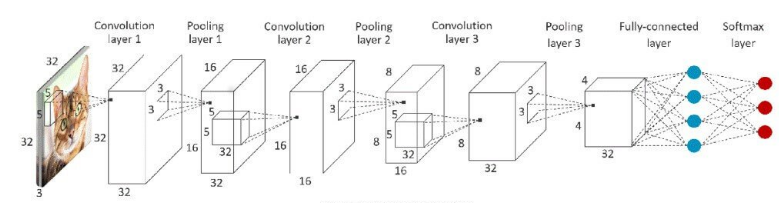

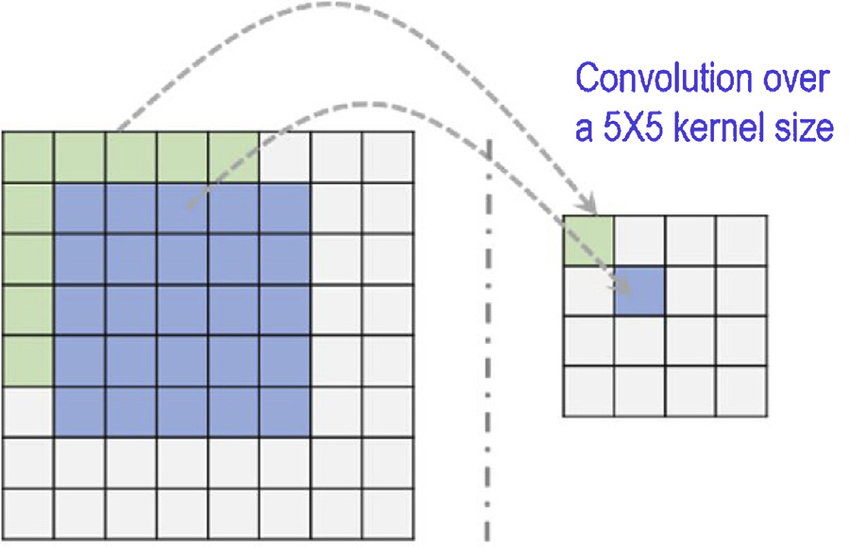

In [ ]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
    	# super함수는 CNN class의 부모 class인 nn.Module을 초기화
        super(CNN, self).__init__()

        # batch_size = 100
        self.layer = nn.Sequential(
            # 이미지 차원 : [batchsize, c, w, h]
            # 이미지 사이즈의 변화 입니다. [batch_size,3,32,32] -> [batch_size,16,28,28]
            # Padding = 0 , stride = 1 이 default 입니다.

            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5),
            nn.ReLU(),

            # [batch_size,16,28,28] -> [batch_size,32,24,24]
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),
            nn.ReLU(),

            # [batch_size,32,24,24] -> [batch_size,32,12,12]
            nn.MaxPool2d(kernel_size=2,stride=2),

            # [batch_size,32,12,12] -> [batch_size,64,8,8]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(),

            # [batch_size,64,8,8] -> [batch_size,64,4,4]
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.fc_layer = nn.Sequential(
        	# [batch_size,64*4*4] -> [batch_size,100]
            nn.Linear(1024,100),
            nn.ReLU(),
            # [batch_size,100] -> [batch_size,10]
            nn.Linear(100,10)
        )

    def forward(self,x):
    	# self.layer에 정의한 연산 수행
        out = self.layer(x)
        # view 함수를 이용해 텐서의 형태를 [batch_size,나머지]로 변환
        out = out.view(batch_size,-1)
        # self.fc_layer 정의한 연산 수행
        out = self.fc_layer(out)
        return out

# Multi Layer Perceptron vs Convolutional Neural Network
CIFAR 10 data로 MLP와 CNN의 성능 비교하기

In [ ]:
import torch.optim as optim
epoch = 10
# 정의한 MLP모델 불러오기
net_mlp = MLP(3*32*32,[200,100,50],10)
# 정의한 CNN모델 불러오기
net_cnn = CNN()
# 모델을 GPU에 올리기
net_mlp.cuda()
net_cnn.cuda()
# MLP와 CNN optimizer 각각 정의 하기
optimizer= optim.Adam(net_mlp.parameters(), lr= 0.0001 , weight_decay = 1e-8)
optimizer_2= optim.Adam(net_cnn.parameters(), lr= 0.0001 , weight_decay = 1e-8)
# Classification을 위한 CrossEntropyloss 정의
loss = nn.CrossEntropyLoss()

MLP와 CNN 모델을 학습합니다.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn import Sigmoid,BCELoss,CrossEntropyLoss
import torch.nn.functional as F
import torch.optim as optim
import torch
from tqdm import tqdm


net_mlp.train()
net_cnn.train()
# epoch 당 MLP, CNN 학습
for i in tqdm(range(epoch)):
  tloss = 0
  total = 0
# MLP 모델 학습
  for i , data in enumerate(trainloader):

    image, label = data
    image= image.cuda()
    label = label.cuda()

    output = net_mlp(image)
    (16,10)
    output = F.softmax(output,dim=1)
    train_loss = loss(output, label)
    tloss += train_loss.item()
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad(True)
    total += label.shape[0]
  print(f"\nMLP Loss :{tloss/total}")

  ptloss = 0
  ptotal = 0
# CNN 모델 학습
  for i , data in enumerate(trainloader):

    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = net_cnn(image)
    output = F.softmax(output,dim=1)

    train_loss_2 = loss(output, label)
    ptloss += train_loss_2.item()
    train_loss_2.backward()
    optimizer_2.step()
    optimizer_2.zero_grad(True)
    ptotal += label.shape[0]
  print(f"\nCNN Loss :{ptloss/ptotal}")


  0%|          | 0/10 [00:00<?, ?it/s]


MLP Loss :0.13204580446004868


 10%|█         | 1/10 [00:32<04:54, 32.70s/it]


CNN Loss :0.13363710350751876

MLP Loss :0.12844143426418306


 20%|██        | 2/10 [00:57<03:45, 28.24s/it]


CNN Loss :0.12860152328014374

MLP Loss :0.12716399133682252


 30%|███       | 3/10 [01:22<03:07, 26.81s/it]


CNN Loss :0.12637026470422744

MLP Loss :0.12646219149827956


 40%|████      | 4/10 [01:48<02:36, 26.16s/it]


CNN Loss :0.12473419664382934

MLP Loss :0.12589353843212128


 50%|█████     | 5/10 [02:13<02:08, 25.77s/it]


CNN Loss :0.12341935031175613

MLP Loss :0.12540995002269745


 60%|██████    | 6/10 [02:38<01:41, 25.49s/it]


CNN Loss :0.12217451044321061

MLP Loss :0.125013272895813


 70%|███████   | 7/10 [03:02<01:15, 25.23s/it]


CNN Loss :0.12119661362171173

MLP Loss :0.12456433485746383


 80%|████████  | 8/10 [03:27<00:50, 25.07s/it]


CNN Loss :0.12005576520204544

MLP Loss :0.12423794256925583


 90%|█████████ | 9/10 [03:52<00:25, 25.03s/it]


CNN Loss :0.11911673988580704

MLP Loss :0.12386883175849915


100%|██████████| 10/10 [04:16<00:00, 25.70s/it]


CNN Loss :0.11831661043167115


MLP와 CNN 성능을 확인합니다.

In [ ]:

net_mlp.eval()
net_cnn.eval()

# 학습한 각 model을 test 합니다.
with torch.no_grad():
  acc = torch.tensor(0)
  acc_2 = torch.tensor(0)
  k = 0
  k_2 = 0
# MLP model 정확도를 test
  for i ,data in enumerate(testloader):
    image, label = data
    image= image.cuda()
    label = label.cuda()

    output = net_mlp(image)
    output = torch.argmax(output, dim = 1)
    accuracy = torch.sum(output==label)
    acc = acc + accuracy
    k +=label.shape[0]
# CNN model 정확도를 test

  for i ,data in enumerate(testloader):
    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = net_cnn(image)
    output = torch.argmax(output, dim = 1)
    accuracy = torch.sum(output==label)
    acc_2 = acc_2 + accuracy
    k_2 +=label.shape[0]


acc_1 = 100*(acc/k)
acc_2 = 100*(acc_2/k_2)

print(f"MLP accuaracy : {acc_1}")
print(f"CNN accuaracy : {acc_2}")



MLP accuaracy : 44.36000061035156
CNN accuaracy : 55.119998931884766


#[Exercise]
#MLP VS CNN 코드 직접 구성하기
요구사항

1) Class 개수가 100개인 CIFAR 100 data를 학습할 수 있도록 fc layer 파라미터를 조정하기

2) Convolution layer 의 주어진 파라미터에 맞춰서 구성하기

3) MLP layer를 주어진 조건에 맞춰서 forward 구성하기

convolution layer 정의
nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
    	# super함수는 CNN class의 부모 class인 nn.Module을 초기화
        super(CNN, self).__init__()

        # batch_size = 100
        self.layer = nn.Sequential(
            # 이미지 차원 : [batchsize, c, w, h]
            # 이미지 사이즈의 변화 입니다.
            # Padding = 0 , stride = 1 이 default 입니다.



            #[batch_size,3,32,32] -> [batch_size,16,28,28]
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5),
            nn.ReLU(),

            # Kernal size 는 5로 고정해주세요
            # [batch_size,16,28,28] -> [batch_size,32,28,28]
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5, stride = 1 , padding = 2),
            nn.ReLU(),

            # [batch_size,32,28,28] -> [batch_size,32,14,14]
            nn.MaxPool2d(kernel_size=2,stride=2),

            # Kernal size 는 5로 고정해주세요
            # [batch_size,32,14,14] -> [batch_size,64,10,10]
            nn.Conv2d(in_channels =32, out_channels =64,kernel_size
                      =5),
            nn.ReLU(),




            # [batch_size,64,10,10] -> [batch_size,64,5,5]
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.fc_layer = nn.Sequential(
        	# [batch_size,?????] -> [batch_size,100]
            nn.Linear(64*5*5,100),
            nn.ReLU(),
            #[batch_size,100] -> [batch_size,n_classes]
            nn.Linear(100,100)
        )

    def forward(self,x):
    	# self.layer에 정의한 연산 수행
        out = self.layer(x)
        # view 함수를 이용해 텐서의 형태를 [batch_size,나머지]로 변환
        out = out.view(batch_size,-1)
        # self.fc_layer 정의한 연산 수행
        out = self.fc_layer(out)
        return out

4개의 Linear layer 사이에 3개의 Relu function 을 구성하기

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
  def __init__(self,in_channel,hidden_dim, out_channel):
    super().__init__()

    # MLP의 기본이 되는 fc layer 4개를 구상합니다.
    self.Linear1 = nn.Linear(in_channel,hidden_dim[0])
    self.Linear2 = nn.Linear(hidden_dim[0],hidden_dim[1])
    self.Linear3 = nn.Linear(hidden_dim[1],hidden_dim[2])
    self.Linear4 = nn.Linear(hidden_dim[2],out_channel)





  def forward(self,x):
    # batch size를 제외한 차원을 flatten 시켜줍니다.

    x = torch.reshape(x,(16,-1))

    # 한개의 layer마다 fc layer와 relu function 을 쌓아줍니다.

    x = self.Linear1(x)
    x = F.relu(x)
    x = self.Linear2(x)
    x = F.relu(x)
    x = self.Linear3(x)
    x = F.relu(x)
    x = self.Linear4(x)



    return x





MLP와 CNN 학습을 진행합니다.

In [ ]:
import torch.optim as optim
epoch = 10
# 정의한 MLP모델 불러오기
net_mlp = MLP(3*32*32,[200,100,50],100)
# 정의한 CNN모델 불러오기
net_cnn = CNN()
# 모델을 GPU에 올리기
net_mlp.cuda()
net_cnn.cuda()
# MLP와 CNN optimizer 각각 정의 하기
optimizer= optim.Adam(net_mlp.parameters(), lr= 0.0001 , weight_decay = 1e-8)
optimizer_2= optim.Adam(net_cnn.parameters(), lr= 0.0001 , weight_decay = 1e-8)
# Classification을 위한 CrossEntropyloss 정의
loss = nn.CrossEntropyLoss()

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn import Sigmoid,BCELoss,CrossEntropyLoss
import torch.nn.functional as F
import torch.optim as optim
import torch
from tqdm import tqdm


net_mlp.train()
net_cnn.train()
# epoch 당 MLP, CNN 학습
for i in tqdm(range(epoch)):
  tloss = 0
  total = 0
# MLP 모델 학습
  for i , data in enumerate(trainloader_100):

    image, label = data
    image= image.cuda()
    label = label.cuda()

    output = net_mlp(image)
    output = F.softmax(output,dim=1)
    train_loss = loss(output, label)
    tloss += train_loss.item()
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad(True)
    total += label.shape[0]
  print(f"\nMLP Loss :{tloss/total}")

  ptloss = 0
  ptotal = 0
# CNN 모델 학습
  for i , data in enumerate(trainloader_100):

    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = net_cnn(image)
    output = F.softmax(output,dim=1)

    train_loss_2 = loss(output, label)
    ptloss += train_loss_2.item()
    train_loss_2.backward()
    optimizer_2.step()
    optimizer_2.zero_grad(True)
    ptotal += label.shape[0]
  print(f"\nCNN Loss :{ptloss/ptotal}")


  0%|          | 0/10 [00:00<?, ?it/s]


MLP Loss :0.27149497110843657


 10%|█         | 1/10 [00:25<03:45, 25.09s/it]


CNN Loss :0.2779436302471161

MLP Loss :0.2677591751098633


 20%|██        | 2/10 [00:50<03:23, 25.50s/it]


CNN Loss :0.2766315948200226

MLP Loss :0.2664021392774582


 30%|███       | 3/10 [01:16<02:57, 25.36s/it]


CNN Loss :0.27622993469238283

MLP Loss :0.2654062326812744


 40%|████      | 4/10 [01:41<02:32, 25.39s/it]


CNN Loss :0.2757374378633499

MLP Loss :0.26462616416454315


 50%|█████     | 5/10 [02:06<02:06, 25.26s/it]


CNN Loss :0.27524911319732664

MLP Loss :0.2639313583087921


 60%|██████    | 6/10 [02:31<01:41, 25.30s/it]


CNN Loss :0.27460402005195617

MLP Loss :0.2633696815252304


 70%|███████   | 7/10 [02:57<01:16, 25.50s/it]


CNN Loss :0.27188256878376005

MLP Loss :0.2628801557731628


 80%|████████  | 8/10 [03:23<00:50, 25.46s/it]


CNN Loss :0.2712099351787567

MLP Loss :0.26240211697101595


 90%|█████████ | 9/10 [03:48<00:25, 25.35s/it]


CNN Loss :0.27077154324531555

MLP Loss :0.26192403444767


100%|██████████| 10/10 [04:13<00:00, 25.36s/it]


CNN Loss :0.27047654628753665


#Resnet model 구성하기



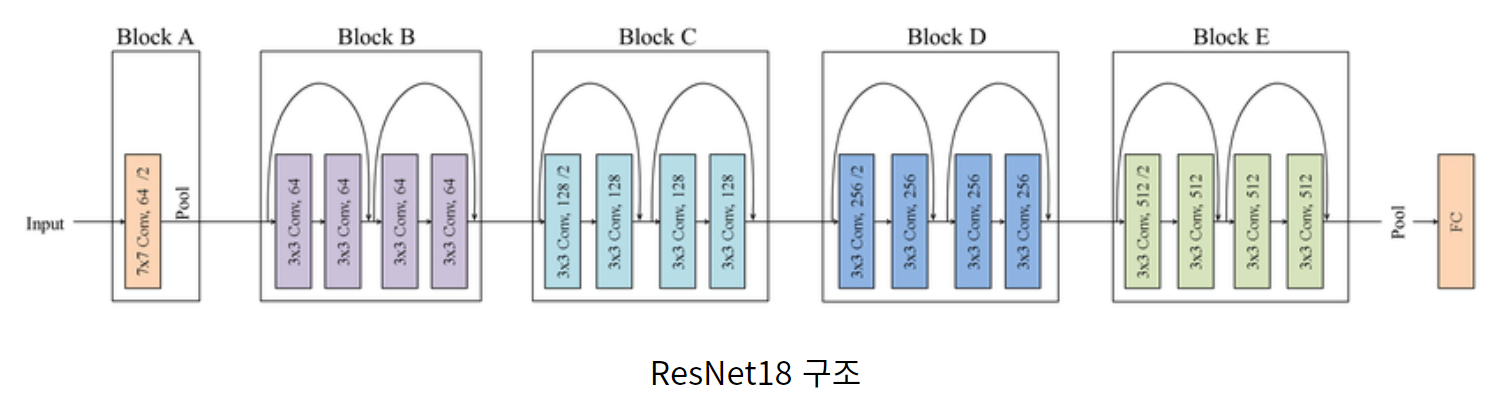

Basic, Bottle Neck 구조

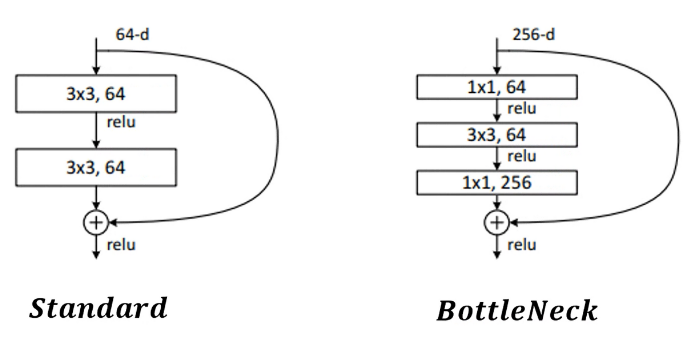

In [ ]:
import torch.nn as nn
class BasicBlock(nn.Module):

    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)

        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=100, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        # output size(1,1) 에 맞춰서 pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

### Pretrain 성능 검증 Tutorial
CIFAR 100 data 로 pretrain 을 진행 한 후 CIFAR 10 data로 전이학습을 하여 성능을 높여보는 Tutorial

CIFAR 100 data로 pretrain model 확보를 위한 resnet 학습을 진행합니다.

In [ ]:
epoch = 3
net = resnet18().cuda()
optimizer= optim.Adam(net.parameters(), lr= 0.0001 , weight_decay = 1e-8)
loss = nn.CrossEntropyLoss()
net.train()
print('')


In [ ]:
### CIFAR100 pretrain
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn import Sigmoid,BCELoss,CrossEntropyLoss
import torch.nn.functional as F
import torch.optim as optim
import torch
from tqdm import tqdm


for i in tqdm(range(epoch)):
  tloss = 0
  total = 0
  for i , data in enumerate(trainloader_100):

    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = net(image)
    output = F.softmax(output)
    train_loss = loss(output, label)
    tloss += train_loss.item()
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad(True)
    total += label.shape[0]
  print(f"\nloss 값 : {tloss/total}")


### Pretrained 모델 활용을 위한 학습이 끝난 model의 weight를 저장합니다.
torch.save(net.state_dict(),"/content/drive/MyDrive/resnetweight.pt")





#Weight 파일을 다운 받습니다.

In [ ]:
#링크를 클릭하여 weight 파일을 다운받고 /content위치에 옮겨놓습니다
https://drive.google.com/file/d/1amuK_TD1SSZaqC7fgEeQmhO4HjX7WaLf/view?usp=share_link



#CIFAR 100 data로 사전학습을 진행 하고 CIFAR 10 data로 전이학습을 진행합니다.

전이학습을 진행한 모델과 하지않은 모델 사이의 Loss 와 Accuracy를 비교합니다.

전이학습을 3가지 방법을 통해 진행합니다.

1. 전체 모델 새로 학습하기
2. Convolution base 일부분 고정하고 나머지 계층과 classifier 새로학습하기
3. Convolution base 전체 고정하고 나머지 계층과 classifier 새로학습하기

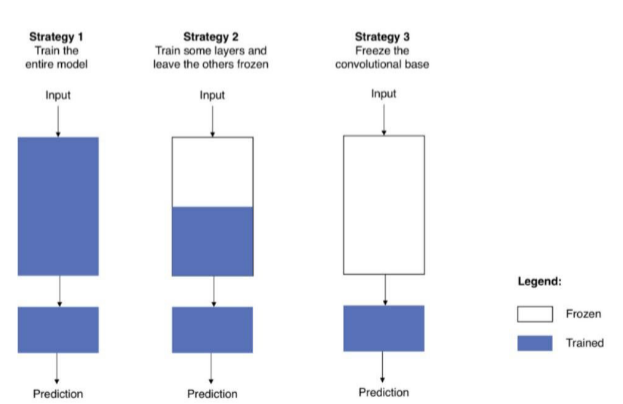

CIFAR 10 데이터를 통해 전이학습과 단순 학습을 진행합니다.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn import Sigmoid,BCELoss,CrossEntropyLoss
import torch.nn.functional as F
import torch.optim as optim
import torch
from tqdm import tqdm



simple_net =  ResNet(BasicBlock, [2,2,2,2],num_classes =10)
pretrained_net = ResNet(BasicBlock, [2,2,2,2],num_classes = 100)
#불러온 Resnet model에 학습 되어있는 pretrained weight을 불러옵니다
pretrained_net.load_state_dict(torch.load("/content/drive/MyDrive/weight.pt"))

#Model 의 Classifier layer를 초기화 합니다.
num_ftrs = pretrained_net.fc.in_features
pretrained_net.fc = nn.Linear(num_ftrs, 10)
#Model을 Gpu에 올립니다.
pretrained_net.cuda()
simple_net.cuda()
optimizer= optim.Adam(pretrained_net.parameters(), lr= 0.0001 , weight_decay = 1e-8)
optimizer_2= optim.Adam(simple_net.parameters(), lr= 0.0001 , weight_decay = 1e-8)
loss = nn.CrossEntropyLoss()
pretrained_net.train()
simple_net.train()
epoch = 3
for i in tqdm(range(epoch)):
  tloss = 0
  total = 0
  for i , data in enumerate(trainloader):

    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = pretrained_net(image)
    output = F.softmax(output,dim=1)
    train_loss = loss(output, label)
    tloss += train_loss.item()
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad(True)
    total += label.shape[0]
  print(f"\nPretrained Loss :{tloss/total}")

  ptloss = 0
  ptotal = 0
  for i , data in enumerate(trainloader):

    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = simple_net(image)
    output = F.softmax(output,dim=1)
    train_loss_2 = loss(output, label)
    ptloss += train_loss_2.item()
    train_loss_2.backward()
    optimizer_2.step()
    optimizer_2.zero_grad(True)
    ptotal += label.shape[0]
  print(f"\nNo Pretrained Loss :{ptloss/ptotal}")



  0%|          | 0/3 [00:00<?, ?it/s]


Pretrained Loss :0.10626655807733536


 33%|███▎      | 1/3 [02:22<04:44, 142.48s/it]


No Pretrained Loss :0.12743729847192764

Pretrained Loss :0.10450163891553879


 67%|██████▋   | 2/3 [04:40<02:20, 140.08s/it]


No Pretrained Loss :0.1217109058380127

Pretrained Loss :0.10411078832626343


100%|██████████| 3/3 [07:09<00:00, 143.27s/it]


No Pretrained Loss :0.11903455013990402


전이학습을 진행한 모델과 하지않은 모델 사이의 Accuracy를 비교합니다.

In [ ]:


pretrained_net.eval()
simple_net.eval()
with torch.no_grad():
  acc = torch.tensor(0)
  acc_2 = torch.tensor(0)
  k = 0
  k_2 = 0

  for i ,data in enumerate(testloader):
    image, label = data
    image= image.cuda()
    label = label.cuda()

    output = pretrained_net(image)
    output = torch.argmax(output, dim = 1)
    accuracy = torch.sum(output==label)
    acc = acc + accuracy
    k +=label.shape[0]

  for i ,data in enumerate(testloader):
    image, label = data
    image= image.cuda()
    label = label.cuda()

    output = simple_net(image)
    output = torch.argmax(output, dim = 1)
    accuracy = torch.sum(output==label)
    acc_2 = acc_2 + accuracy
    k_2 +=label.shape[0]
acc_1 = 100*(acc/k)
acc_2 = 100*(acc_2/k_2)

print(f"Pre accuaracy : {acc_1}")
print(f"No Pre accuaracy : {acc_2}")

Pre accuaracy : 72.52999877929688
No Pre accuaracy : 56.43000030517578


#2. Convolution base 일부분 고정하고 나머지 계층과 classifier 새로학습하기


In [ ]:
class ResNet_pre(nn.Module):
    def __init__(self, block, num_block, num_classes=100, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output.detach())

        # Detach 를 통해서 gradient descent를 끊어서 Freeze를 시킵니다.
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)




In [ ]:
net = ResNet_pre(BasicBlock, [2,2,2,2],num_classes = 100)
net.load_state_dict(torch.load("/content/drive/MyDrive/weight.pt"))
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)
optimizer= optim.Adam(net.parameters(), lr= 0.0001 , weight_decay = 1e-8)
loss = nn.CrossEntropyLoss()
net.cuda()

ResNet_pre(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [ ]:
net.train()
epoch = 1
for i in tqdm(range(epoch)):
  tloss = 0
  total = 0
  for i , data in enumerate(trainloader):

    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = net(image)

    output = F.softmax(output,dim=1)
    train_loss = loss(output, label)
    tloss += train_loss.item()
    train_loss.backward()
    optimizer.step()


    breakpoint()
    optimizer.zero_grad(True)
    total += label.shape[0]
  print(f"\nPretrained Loss :{tloss/total}")

net.eval()

with torch.no_grad():
  acc = torch.tensor(0)
  acc_2 = torch.tensor(0)
  k = 0
  k_2 = 0

  for i ,data in enumerate(testloader):
    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = net(image)
    output = torch.argmax(output, dim = 1)
    accuracy = torch.sum(output==label)
    acc = acc + accuracy

    k +=label.shape[0]


acc_1 = 100*(acc/k)


print(f"Pre accuaracy : {acc_1}")


  0%|          | 0/1 [00:00<?, ?it/s]
PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.8/bdb.py", line 334, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-27-e80f270abd86>(21)<module>()
-> optimizer.zero_grad(True)
(Pdb) net.conv1[0].weight[0][0]
tensor([[ 0.0455,  0.0020, -0.0140,  0.0075,  0.0053,  0.0433,  0.0265],
        [ 0.0776,  0.0813, -0.0228, -0.0527, -0.0286, -0.0485,  0.0141],
        [ 0.0357,  0.0600, -0.0448,  0.0108, -0.0319, -0.0228, -0.0084],
        [ 0.0322,  0.0792,  0.0040, -0.0620, -0.0290, -0.0259, -0.0541],
        [ 0.0850,  0.0752,  0.0208, -0.0114, -0.0681, -0.0659, -0.0474],
        [ 0.0673,  0.0503,  0.0284, -0.0356,  0.0095, -0.0526, -0.0529],
        [ 0.0691,  0.0631, -0.0184, -0.0177, -0.0085,  0.0353, -0.0137]],
       device='cuda:0', grad_fn=<SelectBackward0>)
(Pdb) c



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.8/bdb.py", line 345, in set_continue
    sys.settrace(None)



> <ipython-input-27-e80f270abd86>(20)<module>()
-> breakpoint()
(Pdb) net.conv1[0].weight[0][0]
tensor([[ 0.0455,  0.0020, -0.0140,  0.0075,  0.0053,  0.0433,  0.0265],
        [ 0.0776,  0.0813, -0.0228, -0.0527, -0.0286, -0.0485,  0.0141],
        [ 0.0357,  0.0600, -0.0448,  0.0108, -0.0319, -0.0228, -0.0084],
        [ 0.0322,  0.0792,  0.0040, -0.0620, -0.0290, -0.0259, -0.0541],
        [ 0.0850,  0.0752,  0.0208, -0.0114, -0.0681, -0.0659, -0.0474],
        [ 0.0673,  0.0503,  0.0284, -0.0356,  0.0095, -0.0526, -0.0529],
        [ 0.0691,  0.0631, -0.0184, -0.0177, -0.0085,  0.0353, -0.0137]],
       device='cuda:0', grad_fn=<SelectBackward0>)
(Pdb) net.fc.weight[0][:24]
tensor([-0.0161,  0.0228, -0.0126, -0.0373, -0.0065,  0.0205, -0.0160,  0.0066,
         0.0403, -0.0261,  0.0203,  0.0152, -0.0361, -0.0322, -0.0429, -0.0162,
         0.0390, -0.0311, -0.0283,  0.0012, -0.0172, -0.0076,  0.0189, -0.0263],
       device='cuda:0', grad_fn=<SliceBackward0>)
(Pdb) c
> <ipython-inp

#[Exercise]

#3. Convolution base 전체 고정하고 나머지 계층과 classifier 새로학습하기

In [ ]:
class ResNet_pre(nn.Module):
    def __init__(self, block, num_block, num_classes=100, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output.detach())

        # Detach 를 통해서 gradient descent를 끊어서 Freeze를 시킵니다.
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)




#[Exercise]

#VGGNet Pretrain 실습 직접 짜보기
위에 진행한 것과 비슷하게 VGGnet model을 CIFAR 100 data로 pretrain 한후 CIFAR 10 data로 학습하는 Tutorial


1. VGGNet model 불러와서 CIFAR 100 data로 3epoch 만 학습한 후 weight 저장합니다
2. 학습된 Pretrained model을 불러온 후 fcs layer를 초기화 시킨후 CIFAR 10 학습 진행하기
3. Pretrain 진행하기

#VGGNet 구성하기

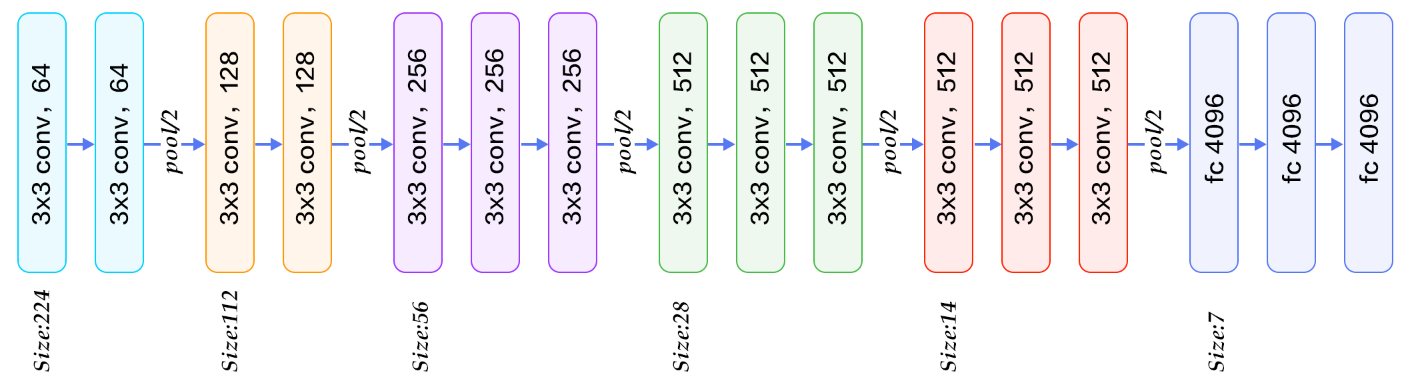

In [ ]:
#VGG type 별 filter 개수 지정
VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']
}
import torch.nn as nn

class VGGnet(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=10, init_weights=True):
        super(VGGnet,self).__init__()
        self.in_channels = in_channels

        # create conv_layers corresponding to VGG type
        self.conv_layers = self.create_conv_laters(VGG_types[model])
        self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(512, 512),
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(512, 512),
                nn.ReLU(True),


            )
        self.fcs = nn.Linear(512, 100)

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 512 )

        x = self.fc(x)
        x = self.fcs(x)
        return x

    # defint weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    # define a function to create conv layer taken the key of VGG_type dict
    def create_conv_laters(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:
            if type(x) == int: # int means conv layer
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        return nn.Sequential(*layers)

# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = VGGnet('VGG16', in_channels=3, num_classes=10, init_weights=True).to(device)


In [ ]:
import torch.optim as optim
epoch = 1
### VGGNet16 모델을 불러옵니다.
net = ????
### Adam optimizer 를 불러옵니다.
optimizer = ????
### Classification을 위한 loss모듈을 불러옵니다.
loss = ????



In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn import Sigmoid,BCELoss,CrossEntropyLoss
import torch.nn.functional as F
import torch.optim as optim
import torch
from tqdm import tqdm



net.train()
for i in tqdm(range(epoch)):
  tloss = 0
  total = 0
  for i , data in enumerate(trainloader_100):

    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = net(image)
    output = F.softmax(output, dim = 1)
    train_loss = loss(output, label)
    tloss += train_loss.item()
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad(True)
    total += label.shape[0]
  print(f"\nloss 값 : {tloss/total}")


### Pretrained 모델 활용을 위한 학습이 끝난 model의 weight를 저장합니다.
torch.save(net.state_dict(),"/content/drive/MyDrive/Vggweight.pt")





직접 학습된 pretrain model 불러와서 CIFAR 10 dataset 으로
학습해보기


In [ ]:
net = VGGnet('VGG16', in_channels=3, num_classes=100, init_weights=True).to(device)
net.load_state_dict(torch.load("/content/drive/MyDrive/Vggweight.pt"))
num_ftrs = net.fcs.in_features
net.fcs = nn.Linear( num_ftrs , 10)
optimizer= optim.Adam(net.parameters(), lr= 0.0001 , weight_decay = 1e-8)
loss = nn.CrossEntropyLoss()

net.cuda()
epoch = 1

net.train()
for i in tqdm(range(epoch)):
  tloss = 0
  total = 0
  for i , data in enumerate(trainloader):

    image, label = data
    ### cuda 에 데이터 올리기
    ????
    ????
    output = ?????
    output = F.softmax(output,dim=1)
    train_loss = loss(output, label)
    tloss += train_loss.item()



    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad(True)
    total += label.shape[0]
  print(f"\nPretrained Loss :{tloss/total}")

net.eval()
with torch.no_grad():
  acc = torch.tensor(0)
  k = 0

  for i ,data in enumerate(testloader):
    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = net(image)
    # output 중에서 가장 확률값이 높은 정답 인덱스 추출하기
    output = ????
    accuracy = torch.sum(output==label)
    acc = acc + accuracy
    k +=label.shape[0]



print(100*(acc/k))



#Answer

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
    	# super함수는 CNN class의 부모 class인 nn.Module을 초기화
        super(CNN, self).__init__()

        # batch_size = 100
        self.layer = nn.Sequential(
            # 이미지 차원 : [batchsize, c, w, h]
            # 이미지 사이즈의 변화 입니다.
            # Padding = 0 , stride = 1 이 default 입니다.
            #[batch_size,3,32,32] -> [batch_size,16,28,28]
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5),
            nn.ReLU(),

            # [batch_size,16,28,28] -> [batch_size,32,28,28]
            nn.Conv2d(in_channels= 16, out_channels=32, kernel_size = 5, stride = 1, padding=2),
            nn.ReLU(),

            # [batch_size,32,28,28] -> [batch_size,32,14,14]
            nn.MaxPool2d(kernel_size=2,stride=2),
            # [batch_size,32,14,14] -> [batch_size,64,10,10]
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5),
            nn.ReLU(),

            # [batch_size,64,10,10] -> [batch_size,64,5,5]
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.fc_layer = nn.Sequential(
        	# [batch_size,1600] -> [batch_size,100]
            nn.Linear(1600,100),
            nn.ReLU(),

            nn.Linear(100,100)
        )

    def forward(self,x):
    	# self.layer에 정의한 연산 수행
        out = self.layer(x)
        # view 함수를 이용해 텐서의 형태를 [batch_size,나머지]로 변환
        out = out.view(batch_size,-1)
        # self.fc_layer 정의한 연산 수행
        out = self.fc_layer(out)
        return out

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
  def forward(self,x):
    # batch size를 제외한 차원을 flatten 시켜줍니다.

    x = torch.reshape(x,(16,-1))

    # 한개의 layer마다 fc layer와 relu function 을 쌓아줍니다.

    x = self.Linear1(x)
    x = F.relu(x)
    x = self.Linear2(x)
    x = F.relu(x)
    x = self.Linear3(x)
    x = F.relu(x)
    x = self.Linear4(x)


    return x





In [ ]:
epoch = 1
net = VGGnet('VGG16', in_channels=3, num_classes=100, init_weights=True).to(device)
optimizer= optim.Adam(net.parameters(), lr= 0.0001 , weight_decay = 1e-8)
loss = nn.CrossEntropyLoss()

In [ ]:
net = VGGnet('VGG16', in_channels=3, num_classes=100, init_weights=True).to(device)
net.load_state_dict(torch.load("/content/drive/MyDrive/Vggweight.pt"))
num_ftrs = net.fcs.in_features
net.fcs = nn.Linear( num_ftrs , 10)
optimizer= optim.Adam(net.parameters(), lr= 0.0001 , weight_decay = 1e-8)
loss = nn.CrossEntropyLoss()

net.cuda()
epoch = 1

nets.train()
for i in tqdm(range(epoch)):
  tloss = 0
  total = 0
  for i , data in enumerate(trainloader):

    image, label = data
    ### cuda 에 데이터 올리기
    image = image.cuda()
    label = label.cuda()
    output = net(image)
    # output = torch.argmax(output, dim = 1)
    output = F.softmax(output,dim=1)
    train_loss = loss(output, label)
    tloss += train_loss.item()



    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad(True)
    total += label.shape[0]
  print(f"\nPretrained Loss :{tloss/total}")

net.eval()
with torch.no_grad():
  acc = torch.tensor(0)
  k = 0

  for i ,data in enumerate(testloader):
    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = net(image)

    output = torch.argmax(output, dim = 1)
    accuracy = torch.sum(output==label)
    acc = acc + accuracy
    k +=label.shape[0]



print(100*(acc/k))



In [ ]:
net.eval()
with torch.no_grad():
  acc = torch.tensor(0)
  k = 0

  for i ,data in enumerate(testloader):
    image, label = data
    image= image.cuda()
    label = label.cuda()
    output = net(image)

    output = torch.argmax(output, dim = 1)
    accuracy = torch.sum(output==label)
    acc = acc + accuracy
    k +=label.shape[0]



print(100*(acc/k))

